In [1]:
import os

os.chdir("..")
# print(os.getcwd()) 

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from Models import Generators, Discriminators, LossFunctions
import Models.utils as utils

c:\Users\Jose\Desktop\git\TabularDataGAN\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
df = df.dropna()
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

In [4]:
# Initialize generator
generator = Generators.EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)

In [5]:
# Initialize discriminator
discriminator = Discriminators.Discriminator(input_dim=data_dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-3)

# Loss function
criterion = nn.BCELoss()

In [6]:
t0 = time.time()

num_epochs = 8000
batch_size = 500

all_real_data_torch = torch.tensor(data, dtype=torch.float32)

save_nn_data_list = []
for epoch in range(num_epochs):
    
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    z = torch.randn(batch_size, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    fake_data = generator(z_minmax)

    if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
        print("Fake data contains NaNs or Infs!")
        break

    if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
        print("Real data contains NaNs or Infs!")
        break
    
    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = LossFunctions.custom_loss(fake_data, all_real_data_torch, method="median-iqr-covmat")
    g_loss.backward()
    # g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        save_nn_data_list.append({
            "epoch": epoch,
            "discriminator_loss": d_loss.item(),
            "generator_loss": g_loss.item()
        })

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        if utils.stop_training_func(save_nn_data_list):
            break
    
print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

df_nn = pd.DataFrame(save_nn_data_list)

training_time = time.time() - t0

print("Training time", np.round((training_time)/60, 4), "min")

Epoch 0, D Loss: 1.895071268081665, G Loss: 2.8353700637817383
Epoch 500, D Loss: 0.6516543030738831, G Loss: 1.3892766237258911
Epoch 1000, D Loss: 0.3821358382701874, G Loss: 0.5533032417297363
Epoch 1500, D Loss: 0.26148083806037903, G Loss: 0.3421730101108551
Epoch 2000, D Loss: 0.22147883474826813, G Loss: 0.2955332398414612
Epoch 2500, D Loss: 0.2471371740102768, G Loss: 0.2270449548959732
Epoch 2601, D Loss: 0.19560858607292175, G Loss: 0.2527821958065033
Training time 2.0796 min


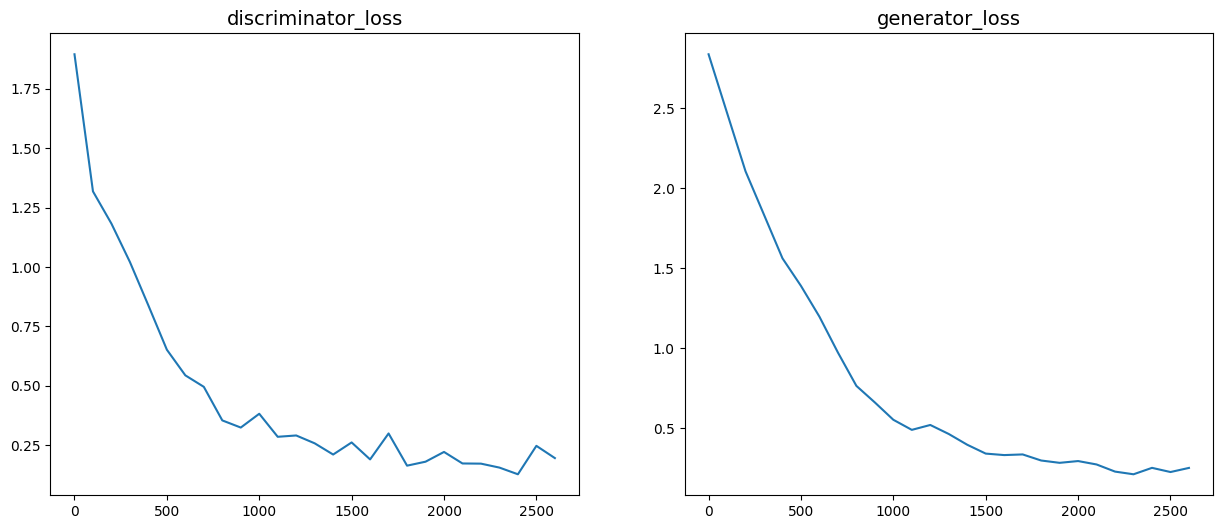

In [7]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [8]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df[numeric_cols])
print(sdv_metadata.to_dict())

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1', 'columns': {'Age': {'sdtype': 'numerical'}, 'SystolicBP': {'sdtype': 'numerical'}, 'DiastolicBP': {'sdtype': 'numerical'}, 'BS': {'sdtype': 'numerical'}, 'BodyTemp': {'sdtype': 'numerical'}, 'HeartRate': {'sdtype': 'numerical'}}}


In [9]:
custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float",
    "BodyTemp": "float",
    "HeartRate": "integer",
}

z = torch.randn(500, data_dim)
z_minmax = (z - z.min()) / (z.max() - z.min())
synthetic_data = generator(z_minmax).detach().numpy()

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)


custom_syn_df = synthetic_df.copy()

for col_name, col_type in custom_metadata_dict.items():
    if col_type == "integer":
        custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

In [10]:
display(custom_syn_df)

corr_list = []
for i_c, i_col in enumerate(numeric_cols[:-1]):
    for j_col in numeric_cols[(i_c+1):]:
        corr_v, p_value = sp.stats.pearsonr(custom_syn_df[i_col].values, custom_syn_df[j_col].values)
        corr_list.append({
            "Feature1": i_col, "Feature2": j_col, "correlation": corr_v, "pvalue": p_value
        })

df_corr = pd.DataFrame(corr_list).sort_values("correlation", ascending=False).reset_index(drop=True)
df_corr

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,33,118,68,8.007893,98.201721,66
1,41,125,74,7.162560,98.085495,82
2,14,133,98,8.360838,98.028755,75
3,28,127,90,7.141222,98.050270,62
4,45,121,81,7.149756,98.083733,78
...,...,...,...,...,...,...
495,23,119,78,7.890346,98.077866,74
496,25,113,60,7.206425,98.109245,79
497,17,111,58,6.945273,98.211212,80
498,43,121,80,7.781454,98.065681,76


,Feature1,Feature2,correlation,pvalue
0,SystolicBP,DiastolicBP,0.802303,1.130543e-113
1,DiastolicBP,BS,0.719112,9.354689e-81
2,Age,SystolicBP,0.618037,5.274254e-54
3,SystolicBP,BS,0.614079,3.756916e-53
4,Age,DiastolicBP,0.463405,5.517864e-28
5,Age,BS,0.288260,5.048209e-11
6,BS,BodyTemp,0.123684,5.616306e-03
7,Age,HeartRate,0.096671,3.067388e-02
8,SystolicBP,HeartRate,0.057257,2.011933e-01
9,DiastolicBP,HeartRate,0.029102,5.161710e-01


In [11]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    sdv_metadata
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 38.80it/s]


Overall Quality Score: 81.38%

Properties:
Column Shapes: 69.65%
Column Pair Trends: 93.1%


In [12]:
quality_report.get_score()

0.8137593202007745

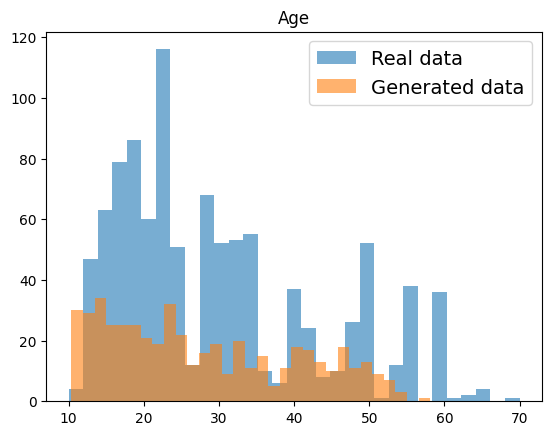

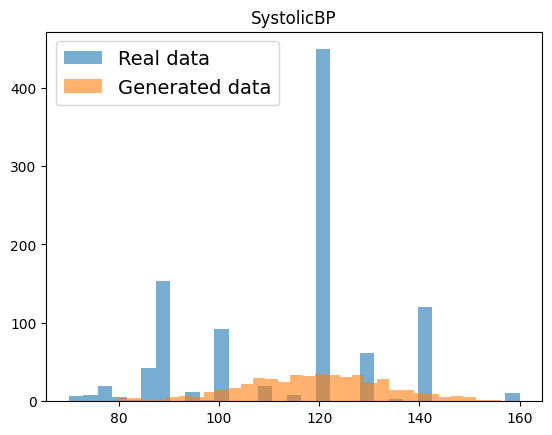

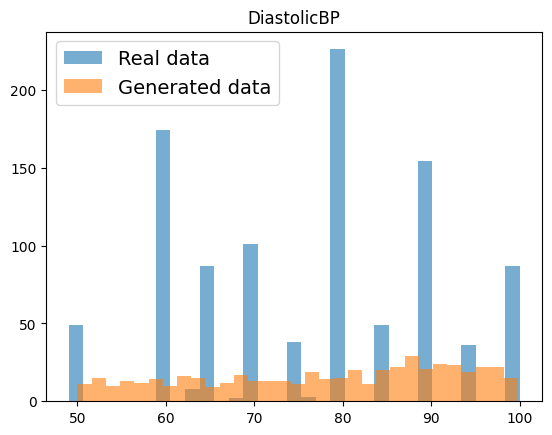

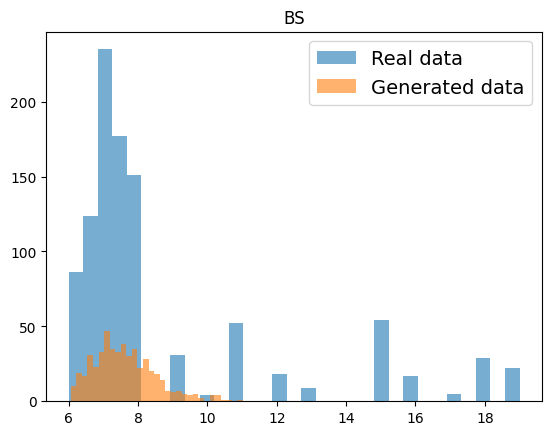

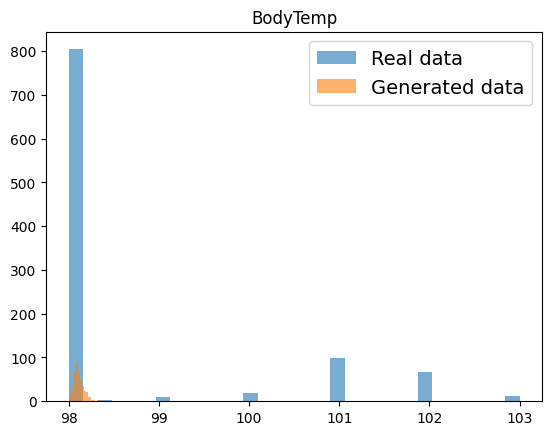

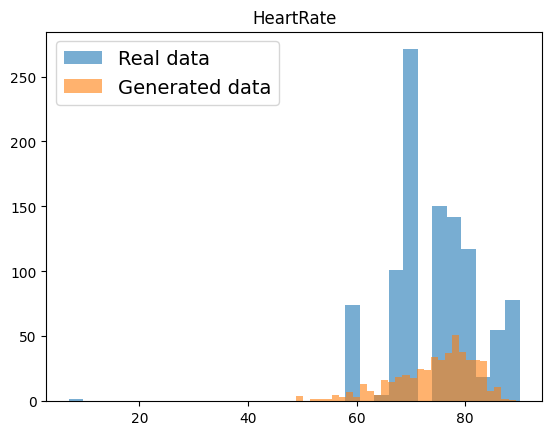

In [13]:
for col in numeric_cols:

    plt.hist(df[col].values, bins=31, alpha=0.6, label="Real data")
    plt.hist(synthetic_df[col].values, bins=31, alpha=0.6, label="Generated data")
    plt.title(col, fontsize=12)
    plt.legend(fontsize=14)
    
    plt.show()

# Check realistic datasets with ML models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as skm

## GAN Generator

In [15]:
custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float_round_1",
    "BodyTemp": "float_round_1",
    "HeartRate": "integer",
}

metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

NUM_GENERATE = 5
NUM_DATA = 500
TARGET_COL = "RealTarget"
FEATURE_LIST = list(custom_metadata_dict.keys())

help_list = []
for i_gen in range(NUM_GENERATE):

    z = torch.randn(NUM_DATA, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    synthetic_data = generator(z_minmax).detach().numpy()

    # Denormalizar
    synthetic_data = scaler.inverse_transform(synthetic_data)

    # Guardar en CSV
    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
    # synthetic_df.to_csv("datos_sinteticos.csv", index=False)


    custom_syn_df = synthetic_df.copy()

    for col_name, col_type in custom_metadata_dict.items():
        if col_type == "integer":
            custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)
        if "round" in col_type:
            round_th = int(col_type.split("_")[-1])
            custom_syn_df[col_name] = custom_syn_df[col_name].round(round_th)

    custom_syn_df[TARGET_COL] = 0

    idx = np.random.randint(0, df.shape[0], NUM_DATA)
    df_real_sample = df.loc[idx]
    df_real_sample[TARGET_COL] = 1

    df_both = pd.concat([df_real_sample, custom_syn_df], ignore_index=True)

    rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=0)

    for i, (train_idx, test_idx) in enumerate(rkf.split(df_both.index)):
        
        help_dict = {
            "i_gen": i_gen,
            "iteration": i
        }
        
        lr = LogisticRegression()
        x_train = df_both.loc[train_idx, FEATURE_LIST]
        y_train = df_both.loc[train_idx, TARGET_COL]
        x_test = df_both.loc[test_idx, FEATURE_LIST]
        y_test = df_both.loc[test_idx, TARGET_COL]
        
        lr.fit(x_train, y_train)
        
        y_pred = lr.predict(x_test)
        
        for k, v in metrics_skm_dict.items():
            help_dict[k] = v(y_test, y_pred)
        
        help_list.append(help_dict)

df_gen_ml_metrics = pd.DataFrame(help_list)


c:\Users\Jose\Desktop\git\TabularDataGAN\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Jose\Desktop\git\TabularDataGAN\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

In [16]:
df_gen_ml_metrics

,i_gen,iteration,accuracy,kappa,f1_score
0,0,0,0.680,0.357688,0.644444
1,0,1,0.715,0.440299,0.691892
2,0,2,0.665,0.332270,0.637838
3,0,3,0.675,0.340503,0.628571
4,0,4,0.735,0.470847,0.713514
...,...,...,...,...,...
95,4,15,0.745,0.485680,0.698225
96,4,16,0.645,0.281813,0.594286
97,4,17,0.625,0.252392,0.556213
98,4,18,0.645,0.299803,0.620321


In [17]:
df_summary_gen_ml = pd.DataFrame(df_gen_ml_metrics[metrics_skm_dict.keys()].mean(axis=0)).T
df_summary_gen_ml["Type"] = "GAN_LinearNN_PINN"

df_summary_gen_ml

,accuracy,kappa,f1_score,Type
0,0.68775,0.375892,0.654727,GAN_LinearNN_PINN


## SDV Generator

In [18]:
from sdv.single_table import GaussianCopulaSynthesizer

In [19]:
metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df)

NUM_DATA = 500
TARGET_COL = "RealTarget"
FEATURE_LIST = list(custom_metadata_dict.keys())

help_list = []

synthesizer = GaussianCopulaSynthesizer(sdv_metadata)
synthesizer.fit(data=df)
synthetic_df_sdv = synthesizer.sample(num_rows=NUM_DATA)

synthetic_df_sdv[TARGET_COL] = 0

idx = np.random.randint(0, df.shape[0], NUM_DATA)
df_real_sample = df.loc[idx]
df_real_sample[TARGET_COL] = 1

df_both = pd.concat([df_real_sample, synthetic_df_sdv], ignore_index=True)

rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=0)

for i, (train_idx, test_idx) in enumerate(rkf.split(df_both.index)):
    
    help_dict = {
        "iteration": i
    }
    
    lr = LogisticRegression()
    x_train = df_both.loc[train_idx, FEATURE_LIST]
    y_train = df_both.loc[train_idx, TARGET_COL]
    x_test = df_both.loc[test_idx, FEATURE_LIST]
    y_test = df_both.loc[test_idx, TARGET_COL]
    
    lr.fit(x_train, y_train)
    
    y_pred = lr.predict(x_test)
    
    for k, v in metrics_skm_dict.items():
        help_dict[k] = v(y_test, y_pred)
    
    help_list.append(help_dict)

df_sdv_ml_metrics = pd.DataFrame(help_list)

In [20]:
df_summary_sdv_ml = pd.DataFrame(df_sdv_ml_metrics[metrics_skm_dict.keys()].mean(axis=0)).T
df_summary_sdv_ml["Type"] = "SDV_Gaussian"

df_summary_sdv_ml

,accuracy,kappa,f1_score,Type
0,0.56625,0.133829,0.513373,SDV_Gaussian


## Comparision

In [21]:
df_gen_ml_metrics["Type"] = "GAN_LinearNN_PINN"
df_sdv_ml_metrics["Type"] = "SDV_Gaussian"

df_compare = pd.concat([df_gen_ml_metrics, df_sdv_ml_metrics], ignore_index=True)

In [22]:
import seaborn as sns

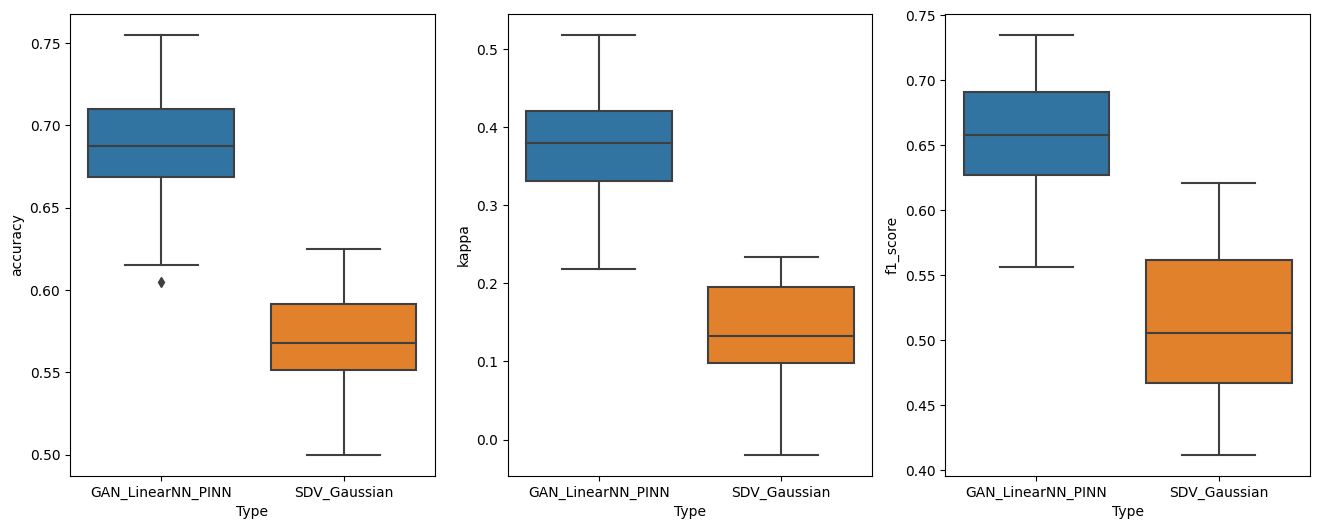

In [24]:
fig = plt.figure(figsize=(16, 6))

for i_k, key in enumerate(metrics_skm_dict.keys()):

    fig.add_subplot(1,3,i_k+1)
    sns.boxplot(data=df_compare, x="Type", y=key)
    # plt.axhline(0.5, linestyle="--", c="red")

plt.show()

# Make a loop

In [25]:
import itertools
from collections import defaultdict

import sklearn.metrics as skm

from sdv.single_table import GaussianCopulaSynthesizer

In [26]:
def generate_combinations(elements, sizes):
    comb_list = []
    for size in sizes:
        comb_list.extend(list(itertools.combinations(elements, size)))
    return comb_list

In [27]:
loss_method = ["median", "iqr", "autocorr", "corrmat", "covmat"]
sizes = np.arange(2, 3+1)
all_comb_list = generate_combinations(loss_method, sizes)
loss_method_list = ["-".join(x) for x in all_comb_list]
loss_method_list.extend(loss_method + ["all"])
print(loss_method_list)
print("Number of methods", len(loss_method_list))

['median-iqr', 'median-autocorr', 'median-corrmat', 'median-covmat', 'iqr-autocorr', 'iqr-corrmat', 'iqr-covmat', 'autocorr-corrmat', 'autocorr-covmat', 'corrmat-covmat', 'median-iqr-autocorr', 'median-iqr-corrmat', 'median-iqr-covmat', 'median-autocorr-corrmat', 'median-autocorr-covmat', 'median-corrmat-covmat', 'iqr-autocorr-corrmat', 'iqr-autocorr-covmat', 'iqr-corrmat-covmat', 'autocorr-corrmat-covmat', 'median', 'iqr', 'autocorr', 'corrmat', 'covmat', 'all']
Number of methods 26


In [28]:
from sdv.metadata import SingleTableMetadata

sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df)

In [29]:
def post_process_data_with_metadata(data, custom_metadata_dict):
    custom_syn_df = data.copy()
    for col_name, col_type in custom_metadata_dict.items():
        if col_type == "integer":
            custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

    return custom_syn_df

In [30]:
def generate_synthetic_data(generator, scaler, df_columns, num_data_generate, data_dim):
    """Generates synthetic data using a GAN-based generator and denormalizes it."""
    z = torch.randn(num_data_generate, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    synthetic_data = generator(z_minmax).detach().numpy()
    synthetic_data_denom = scaler.inverse_transform(synthetic_data)
    return pd.DataFrame(synthetic_data_denom, columns=df_columns)

def evaluate_generator_metrics(real_df, synthetic_df, metadata=sdv_metadata):
    """Evaluates synthetic data quality using a quality report."""
    quality_report = evaluate_quality(real_df, synthetic_df, metadata, verbose=False)
    return quality_report.get_score()

def evaluate_discriminator_metrics(discriminator, real_data, fake_data, sigmoid_th, metrics_skm_dict):
    """Evaluates discriminator performance using real and synthetic data."""
    both_data_torch = torch.cat((real_data, fake_data), dim=0)
    
    true_labels = np.concatenate((np.zeros(real_data.shape[0]), np.ones(fake_data.shape[0])))
    discriminator_score = discriminator(both_data_torch)
    
    disc_score_array = (discriminator_score.detach().numpy()[:, 0] > sigmoid_th).astype(int)

    return {k: skm_func(true_labels, disc_score_array) for k, skm_func in metrics_skm_dict.items()}

def generate_sdv_synthetic_data(df, num_data_generate, metadata=sdv_metadata):
    """Generates synthetic data using SDV GaussianCopulaSynthesizer."""
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(data=df)
    return synthesizer.sample(num_rows=num_data_generate)

In [31]:
metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

num_epochs = 5000
batch_size = 500
num_generate_th = 30
num_data_generate = 500
sigmoid_th = 0.5

save_result_list = []

for loss_method in loss_method_list[:]:

    print(loss_method)
    
    all_real_data_torch = torch.tensor(data, dtype=torch.float32)

    generator = Generators.EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
    optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)
    
    discriminator = Discriminators.Discriminator(input_dim=data_dim)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)
    
    criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data_array = data[idx]
        real_data = torch.tensor(data[idx], dtype=torch.float32)
        
        # Generar datos falsos
        z = torch.randn(batch_size, data_dim)
        z_minmax = (z - z.min()) / (z.max() - z.min())
        fake_data = generator(z_minmax)
    
        if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
            print("Fake data contains NaNs or Infs!")
            break
    
        if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
            print("Real data contains NaNs or Infs!")
            break
        
        # Entrenar Discriminador
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
    
        # Entrenar Generador
        optimizer_g.zero_grad()
        g_loss = LossFunctions.custom_loss(fake_data, all_real_data_torch, method=loss_method)
        g_loss.backward()
        # g_loss.backward()
        optimizer_g.step()

    # #####################
    # ### Generate data ###
    # #####################
    metrics_dict = defaultdict(list)
    for _ in range(num_generate_th):
        # ########################
        # ### Custom Generator ###
        # ########################
        # Generate and process GAN-based synthetic data
        synthetic_df = generate_synthetic_data(generator, scaler, df.columns, num_data_generate, data_dim)
        custom_syn_df = post_process_data_with_metadata(synthetic_df, custom_metadata_dict)

        # Generator Metrics
        qr_score = evaluate_generator_metrics(df[numeric_cols], custom_syn_df)
        metrics_dict["qr_score"].append(qr_score)

        # Discriminator Metrics
        real_data_tensor = torch.tensor(data[np.random.randint(0, data.shape[0], num_data_generate)], dtype=torch.float32)
        fake_data_tensor = torch.tensor(synthetic_df.values, dtype=torch.float32)
        
        disc_metrics = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics.items():
            metrics_dict[k].append(v)

        # #####################
        # ### SDV Generator ###
        # #####################
        # Generate and process SDV-based synthetic data
        synthetic_df_sdv = generate_sdv_synthetic_data(df, num_data_generate)

        # Generator Metrics for SDV
        qr_score_sdv = evaluate_generator_metrics(df[numeric_cols], synthetic_df_sdv)
        metrics_dict["sdv_qr_score"].append(qr_score_sdv)

        # Discriminator Metrics for SDV
        fake_data_tensor_sdv = torch.tensor(synthetic_df_sdv.values, dtype=torch.float32)
        disc_metrics_sdv = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor_sdv, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics_sdv.items():
            metrics_dict[f"sdv_{k}"].append(v)

    del generator, discriminator, optimizer_g, optimizer_d, criterion
    
    dict_help = {"loss_method": loss_method}
    for k, v in metrics_dict.items():
        dict_help[f"mean_{k}"] = np.mean(v)
        if k != "sdv_qr_score": 
            dict_help[f"std_{k}"] = np.std(v)
        
    save_result_list.append(dict_help)

median-iqr
median-autocorr
median-corrmat


KeyboardInterrupt: 

In [32]:
df_results = pd.DataFrame(save_result_list).sort_values("mean_qr_score", ascending=False).reset_index(drop=True)
df_results.head(10)

,loss_method,mean_qr_score,std_qr_score,mean_accuracy,std_accuracy,mean_kappa,std_kappa,mean_f1_score,std_f1_score,mean_sdv_qr_score,mean_sdv_accuracy,std_sdv_accuracy,mean_sdv_kappa,std_sdv_kappa,mean_sdv_f1_score,std_sdv_f1_score
0,median-iqr,0.734661,0.002730,0.501733,0.015893,0.003467,0.031787,0.570040,0.014940,0.848438,0.514167,0.013828,0.028333,0.027655,0.595787,0.013168
1,median-autocorr,0.711948,0.002898,0.454633,0.012839,-0.090733,0.025677,0.519666,0.011979,0.848438,0.478433,0.016633,-0.043133,0.033265,0.538991,0.015394
